# Slow fast dissection to understand the effect of ${\rm shift}_s$, case $I_{\rm app}=20$

${\rm shift}_s$: controls the shift of the voltage dependence of slow inactivation

Model: Hu, version with slow inactivation. Defined [here](utils/models/hu_slow_inact/hu_slow_inact.py).

Script to compute the bifurcation diagram of the fast subsystem: [here](bd_wrt_gna_hu.py).

In [1]:
import utils.simu_helper as simu_helper
import utils.plot_helper as plot_helper
import utils.auto_helper as auto_helper
import bd_wrt_gna_hu

import matplotlib.pyplot as plt
import numpy as np
from drawarrow import ax_arrow

In [ ]:
run_simu = True
run_continuation = True

In [3]:
# model
model_name = "hu_slow_inact"  # full system
model = simu_helper.import_model(model_name)
model_name_fast = "hu"  # fast subsystem
auto_dir = auto_helper.compute_auto_dir(model_name_fast)

# parameter sets
param_set_ids = ["wt", "inact_shift_all_channels"]
my_params = [model.params_default | getattr(model, f"params_{param_set_id}") for param_set_id in param_set_ids]

# applied current
i_app_val = 20
# wait 10 seconds before applying the stimulus
t_start = 10000 # in ms
time_shift = t_start/1000  # in seconds

# temporary initial condition
y_0 = [-60, 0.5, 0.5, 0.5, 0.5, 0.5]

# simulation duration
t_end = 300000 + t_start

## Continuation

In [4]:
if run_continuation:
    bd_wrt_gna_hu.compute_bd(i_app_val)

{1: -68.49970514812864, 2: 0.8327561800093416, 3: 0.6795819131610324, 4: 0.020629349443230912}
directory: utils/models/hu/auto/wt
gfortran -g -fopenmp -O -c hu.f90 -o hu.o
gfortran -g -fopenmp -O hu.o -o hu.exe /Users/llemaire/Documents/auto-07p/lib/*.o
Starting hu ...

  BR    PT  TY  LAB      IAPP        L2-NORM          V             H             N            NBIS     
   1     1  EP    1   0.00000E+00   6.85081E+01  -6.84997E+01   8.32756E-01   6.79582E-01   2.06293E-02
   1    25  HB    2   2.28138E-01   6.63647E+01  -6.63561E+01   7.90285E-01   7.18070E-01   2.39205E-02
   1    40  LP    3   3.38151E-01   6.39525E+01  -6.39438E+01   7.33650E-01   7.57782E-01   2.82231E-02
   1   106  LP    4  -2.40473E+00   5.16383E+01  -5.16292E+01   3.58324E-01   8.98813E-01   6.40492E-02
   1   208  UZ    5   2.00000E+01   4.13260E+01  -4.13146E+01   1.29112E-01   9.54761E-01   1.21420E-01

 Total Time    0.935E-02
hu ... done
/Users/llemaire/Documents/projects/dravet/test_code/slow-nav-inact

## Run or load simulations

In [5]:
accuracy_scaling = 1000000
def run_or_load_long_simu(my_simu):
    # find resting state
    my_simu.model_params["i_app"] = 0
    my_simu.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
    my_simu.plot_time_traces();
    y_0_rest = my_simu.sol.y[:,-1]
    # actual simulation
    my_simu.y_0 = y_0_rest
    my_simu.t_end = t_end
    my_simu.model_params["t_start"] = t_start
    my_simu.model_params["i_app_step_val"] = i_app_val
    if run_simu:
        my_simu.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
        my_simu.save_sol(model_name, i_app_val, id="long_simu")
    else:
        my_simu.load_sol(model_name, i_app_val, id="long_simu")
    my_simu.plot_time_traces();


output/hu_slow_inact/wt/long_simu/sol_i_app_20.pickle
output/hu_slow_inact/inact_shift_all_channels/long_simu/sol_i_app_20.pickle


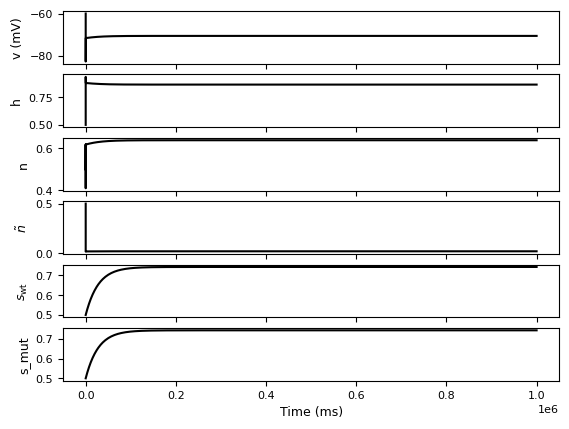

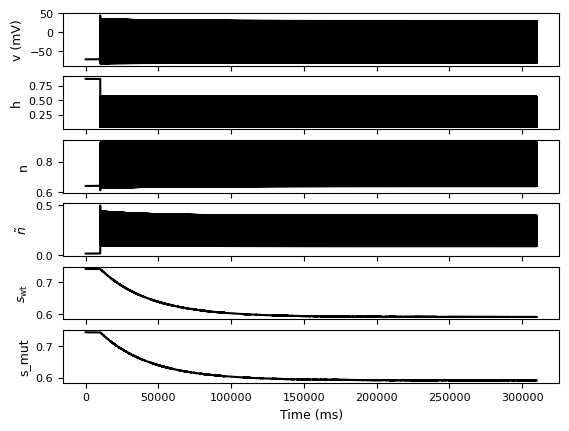

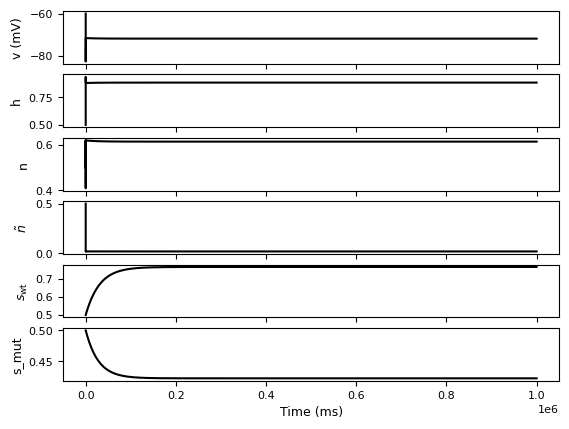

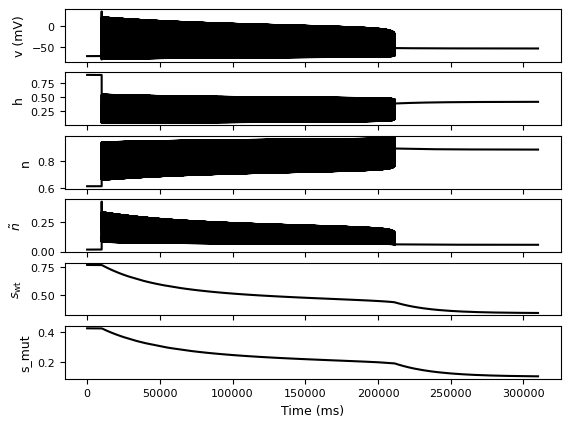

In [6]:
my_simu_tonic_spiking_wt = simu_helper.Simulation(model.rhs, my_params[0], y_0, 1000000, id=param_set_ids[0])
my_simu_tonic_spiking_mut = simu_helper.Simulation(model.rhs, my_params[1], y_0, 1000000, id=param_set_ids[1])

run_or_load_long_simu(my_simu_tonic_spiking_wt)
run_or_load_long_simu(my_simu_tonic_spiking_mut)



## Steady state voltage dependence of slow inactivation

In [7]:
v_vals = np.linspace(-140, 50, 1000)
s_inf_vals = model.s_inf(v_vals, model.params_default)
s_inf_vals_shifted = model.s_inf(v_vals+15, model.params_default)

## Figure

Parsed output data
Parsed output data
Parsed output data
Parsed output data
Parsed output data
Parsed output data
Parsed output data
Parsed output data
Parsed output data


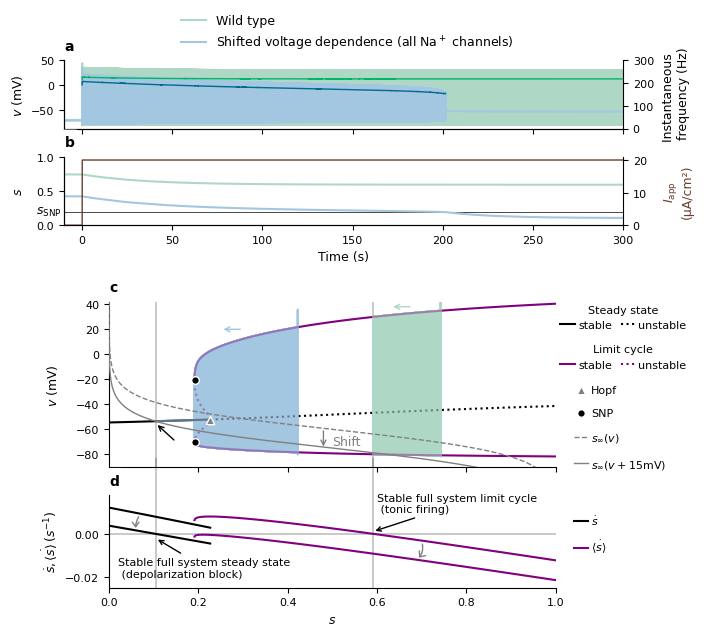

In [8]:
fig = plt.figure()
fig.set_size_inches(plot_helper.fig_size_default["width"], 6.2)

# figure layout
n_rows = 23
n_cols = 50

# time traces
ax_trace_wt_v = plt.subplot2grid((n_rows, n_cols), (1, 0), colspan=50, rowspan=3)
ax_freq = ax_trace_wt_v.twinx()
ax_trace_wt_s = plt.subplot2grid((n_rows, n_cols), (5, 0), colspan=50, rowspan=3)
ax_trace_current = ax_trace_wt_s.twinx()
# plots as a function of s
ax_bd_wrt_s_wt = plt.subplot2grid((n_rows, n_cols), (11, 4), colspan=40, rowspan=7)
ax_slow_flow_wt = plt.subplot2grid((n_rows, n_cols), (19, 4), colspan=40, rowspan=4)

# shared axes
plot_helper.share_axis([ax_bd_wrt_s_wt, ax_slow_flow_wt], x=True)
plot_helper.share_axis([ax_trace_wt_v, ax_trace_wt_s], x=True)

# axes parameters
ax_bd_wrt_s_wt.set_xlim([-0.01, 1.01])
ax_bd_wrt_s_wt.set_ylim([-90, 42])
ax_slow_flow_wt.set_ylim([-0.025, 0.018])
for my_ax in [ax_bd_wrt_s_wt, ax_trace_wt_v]:
    plt.setp(my_ax.get_xticklabels(), visible=False)
for ax in [ax_bd_wrt_s_wt, ax_trace_wt_v]:
    ax.set_ylabel(r"$v$ (mV)")

titles = ["Wild type", "Shifted voltage dependence\n of slow inactivation"]
titles_no_space = ["Wild type", "Shifted voltage dependence (all "+r"$\rm Na^+$"+" channels)"]


#### 1) time traces
current_color = plot_helper.current_color
# applied current
ax = ax_trace_current
ax.plot(my_simu_tonic_spiking_wt.sol.t/1000 - time_shift, model.i_app_step(my_simu_tonic_spiking_wt.sol.t, my_simu_tonic_spiking_wt.model_params), color=current_color, linewidth=1)
# TODO: put current trace in the background
ax.set_ylabel(r"$I_{\rm app}$"+"\n"+u"(\u00B5A/cm\u00B2)", color=current_color)
ax.set_ylim([0, 21])
ax.set_xlim([-time_shift, 300])
ax.set_xticks([0, 60, 120, 180, 240, 300])

# voltage and s traces
s_snp = 0.19146
colors = [plot_helper.color_wt, plot_helper.color_mut_2]
colors_freq = [plot_helper.color_wt_dark, plot_helper.color_mut_2_dark]
for idx, my_simu in enumerate([my_simu_tonic_spiking_wt, my_simu_tonic_spiking_mut]):
    ax = ax_trace_wt_v
    my_simu.plot_voltage_trace(ax, unit="second", time_shift=time_shift, color=colors[idx], label=titles_no_space[idx])
    my_simu.plot_inst_freq(ax, ax_freq=ax_freq, time_shift=10, color=colors_freq[idx], linewidth=1)
    ax_freq.set_ylim([0, 300])
    ax = ax_trace_wt_s
    my_simu.plot_one_trace(ax, time_shift=time_shift, var_idx=-1, unit="second", color=colors[idx])  
ax_trace_wt_s.axhline(y=s_snp, color="k", linewidth=0.5, zorder=-1)
plot_helper.annotate_blended(ax_trace_wt_s, r"$s_{\rm SNP}$", [-0.05, 0.17], rotation=0)

ax_trace_wt_s.set_ylabel(r"$s$")
ax_trace_wt_v.legend(loc=[0.2, 1.05], fontsize=9)
ax_freq.set_ylabel("Instantaneous \n frequency (Hz)")
ax.set_xlabel("Time (s)")
ax.set_ylim([0, 1])



#### 2) fast subsystem + traj. full system
x_fp = 0.1043
x_lc = 0.5919

# bd with respect to s
x_scaling = 1/my_params[0]["g_na_tot"]  # (it's the same in the mutation case)
# wt case
ax = ax_bd_wrt_s_wt
l_eq_stable, l_eq_unstable, l_lc_stable, l_lc_unstable = auto_helper.plot_bd(ax, auto_dir, output_dir="wt", run_names=[f"branch_eq_wrt_gnatot_i_app_{i_app_val}", f"branch_lc_wrt_gnatot_i_app_{i_app_val}"], x_scaling=x_scaling)
l_hopf = auto_helper.plot_special_point(ax, auto_dir, "wt", f"branch_eq_wrt_gnatot_i_app_{i_app_val}", label_auto="HB1", label="HB", label_legend="Hopf", x_scaling=x_scaling, **auto_helper.hopf_plot_args)  # edgecolors="#5f3d56"
l_snp = auto_helper.plot_special_point(ax, auto_dir, "wt", f"branch_lc_wrt_gnatot_i_app_{i_app_val}", label_auto="LP1", label="LPC", label_legend="SNP", x_scaling=x_scaling, **auto_helper.snp_plot_args) #edgecolors="#c36b45"
auto_helper.plot_special_point(ax, auto_dir, "wt", f"branch_lc_wrt_gnatot_i_app_{i_app_val}", label_auto="LP1", label="LPC", x_scaling=x_scaling, var_idx=-1, **auto_helper.snp_plot_args)
l_sinf, = ax.plot(s_inf_vals, v_vals, color="grey", zorder=300, label=r"$s_{\infty}(v)$", linestyle="--", linewidth=1)
l_sinf_shift, = ax.plot(s_inf_vals_shifted, v_vals, color="grey", zorder=300, label=r"$s_{\infty}(v+15{\rm mV})$", linewidth=1)
# arrow
ax.annotate("", xy=(0.48, -76), xytext=(0.48, -59), arrowprops=dict(arrowstyle="->", color="grey"))
ax.text(x=0.50, y=-72.5, s="Shift", color="grey")
# show FP full system
ax.annotate("", xy=(0.104, -55), xytext=(0.15, -70), arrowprops=dict(arrowstyle="->", color="black"))
# trajectories full system
my_simu_tonic_spiking_wt.plot_voltage_wrt_s(ax, zorder=-20, color=plot_helper.color_wt)
my_simu_tonic_spiking_wt.plot_voltage_wrt_s(ax, zorder=200, color=plot_helper.color_wt, alpha=0.6)
my_simu_tonic_spiking_mut.plot_voltage_wrt_s(ax, zorder=-20, color=plot_helper.color_mut_2)
my_simu_tonic_spiking_mut.plot_voltage_wrt_s(ax, zorder=200, color=plot_helper.color_mut_2,alpha=0.6)
ax.axvline(x=x_fp, color="black", zorder=-1000, linewidth=0.3)
ax.axvline(x=x_lc, color="black", zorder=-1000, linewidth=0.3)
# show direction trajs
ax.annotate("", xy=(0.63, 38), xytext=(0.68, 38), arrowprops=dict(arrowstyle="->", color=plot_helper.color_wt))
ax.annotate("", xy=(0.25, 20), xytext=(0.30, 20), arrowprops=dict(arrowstyle="->", color=plot_helper.color_mut_2))
handles_1 = [l_eq_stable, l_eq_unstable]
labels_1 = ["stable", "unstable"]
handles_2 = [l_lc_stable, l_lc_unstable]
labels_2 = ["stable", "unstable"]

leg_1 = ax.legend(handles_1, labels_1, loc=[1, 0.8], ncol=2, handlelength=1.3, columnspacing=0.8, handletextpad=0.3, title="Steady state", title_fontsize=8)
ax.add_artist(leg_1)
leg_2 = ax.legend(handles_2, labels_2, loc=[1, 0.56], ncol=2, handlelength=1.3, columnspacing=0.8, handletextpad=0.3, title="Limit cycle", title_fontsize=8)
ax.add_artist(leg_2)

handles_3 = [l_hopf, l_snp, l_sinf, l_sinf_shift]
labels_3 = ["Hopf", "SNP", r"$s_{\infty}(v)$", r"$s_{\infty}(v+15{\rm mV})$"]
leg_3 = ax.legend(handles_3, labels_3, loc=[1.03, -0.05], handlelength=1.3, handletextpad=0.3, labelspacing=1.2)

#### 3) slow subsystem

# wt case
ax = ax_slow_flow_wt
y_scaling = 1000  # time in second
l_lc = auto_helper.plot_slow_flow_hu(ax, auto_dir, "wt",  f"branch_lc_wrt_gnatot_i_app_{i_app_val}", my_params[0], x_scaling=x_scaling, y_scaling=y_scaling, param_str="GNATOT", color=auto_helper.colors_bif["LP"])
l_eq = auto_helper.plot_ds_dt_fp_hu(ax, auto_dir, "wt", f"branch_eq_wrt_gnatot_i_app_{i_app_val}", model.s_inf, my_params[0], xscaling=x_scaling, y_scaling=y_scaling, shift=0, color="k")
ax.annotate("Stable full system limit cycle \n (tonic firing)", xy=(0.59, 1e-3), xytext=(0.60, 1e-2), arrowprops=dict(arrowstyle="->", color="k"), fontsize=8)
auto_helper.plot_slow_flow_hu(ax, auto_dir, "wt",  f"branch_lc_wrt_gnatot_i_app_{i_app_val}", my_params[1], x_scaling=x_scaling, y_scaling=y_scaling, param_str="GNATOT", color=auto_helper.colors_bif["LP"])
auto_helper.plot_ds_dt_fp_hu(ax, auto_dir, "wt", f"branch_eq_wrt_gnatot_i_app_{i_app_val}", model.s_inf, my_params[1], xscaling=x_scaling, y_scaling=y_scaling, shift=-15, color="k")
ax.annotate("Stable full system steady state \n (depolarization block)", xy=(0.104, -2e-3), xytext=(0.02, -2e-2), arrowprops=dict(arrowstyle="->", color="k"), fontsize=8)
ax_arrow(
    head_position=(0.69, -0.012),
    tail_position=(0.7, -0.0035),
    width=1,
    radius=-0.3,
    color="grey",
    fill_head=False,
    mutation_scale=0.4,
    head_width=7
)

ax_arrow(
    tail_position=(0.07, 0.009),
    head_position=(0.06, 0.0015),
    width=1,
    radius=0.2,
    color="grey",
    fill_head=False,
    mutation_scale=0.4,
    head_width=6
)

ax.axhline(y=0, color="black", zorder=-10, linewidth=0.3)
ax.axvline(x=x_fp, color="black", zorder=-1000, linewidth=0.3, ymax=1.4, clip_on=False)
ax.axvline(x=x_lc, color="black", zorder=-1000, linewidth=0.3, ymax=1.4, clip_on=False)
ax.set_ylabel(r"$\dot{s},\dot{\langle s\rangle}\,(s^{-1})$")
ax.set_xlabel(r"$s$")
ax.set_xlim([0, 1])
handles = [l_eq, l_lc]
labels = [r"$\dot{s}$", r"$\dot{\langle s\rangle}$"]
ax.legend(handles, labels, loc=[1.03, 0.3], handlelength=1.3, handletextpad=0.3, labelspacing=1)

#### beautify
for ax in fig.axes:
    ax.spines[['right', 'top']].set_visible(False)
for ax in [ax_trace_wt_v, ax_trace_current]:
    ax.spines[['right']].set_visible(True)
plt.subplots_adjust(right=0.89, bottom=0.07, top=0.96, left=0.08)

plot_helper.align_labels(fig, shift=-0.07, y=True, axs=[ax_trace_wt_v, ax_trace_wt_s])
plot_helper.align_labels(fig, shift=-0.11, y=True, axs=[ax_bd_wrt_s_wt, ax_slow_flow_wt])
plot_helper.align_labels(fig, shift=1.07, y=True, axs=[ax_freq, ax_trace_current])
# panel labels
plot_helper.lettering(fig, pos=[-0, 1.15], labels=["a", None, "b", None, "c", "d", None])


# save figure
fig_dir = plot_helper.fig_dir
fig_path = f'{fig_dir}/figure_2.png'
plt.savefig(fig_path, format='png', dpi=600)